Using device: cpu
Loading Flowers102 dataset...
Number of training samples: 1020
Number of validation samples: 1020
Number of test samples: 6149
Starting training...
Model saved with val_acc: 0.0961
Epoch 1/5 - 639.4s - train_loss: 4.7084 - train_acc: 0.0186 - val_loss: 4.2673 - val_acc: 0.0961
Model saved with val_acc: 0.2961
Epoch 2/5 - 638.8s - train_loss: 4.1235 - train_acc: 0.0863 - val_loss: 3.1838 - val_acc: 0.2961
Model saved with val_acc: 0.4520
Epoch 3/5 - 638.3s - train_loss: 3.2215 - train_acc: 0.2167 - val_loss: 2.2698 - val_acc: 0.4520
Model saved with val_acc: 0.5716
Epoch 4/5 - 638.1s - train_loss: 2.4643 - train_acc: 0.3559 - val_loss: 1.6527 - val_acc: 0.5716
Model saved with val_acc: 0.7088
Epoch 5/5 - 641.2s - train_loss: 1.9632 - train_acc: 0.4843 - val_loss: 1.1618 - val_acc: 0.7088
Loading best model and evaluating on test set...


<ipython-input-2-2c2d629154c6>:219: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_flowers102_model.pth'))


Test accuracy: 0.6512


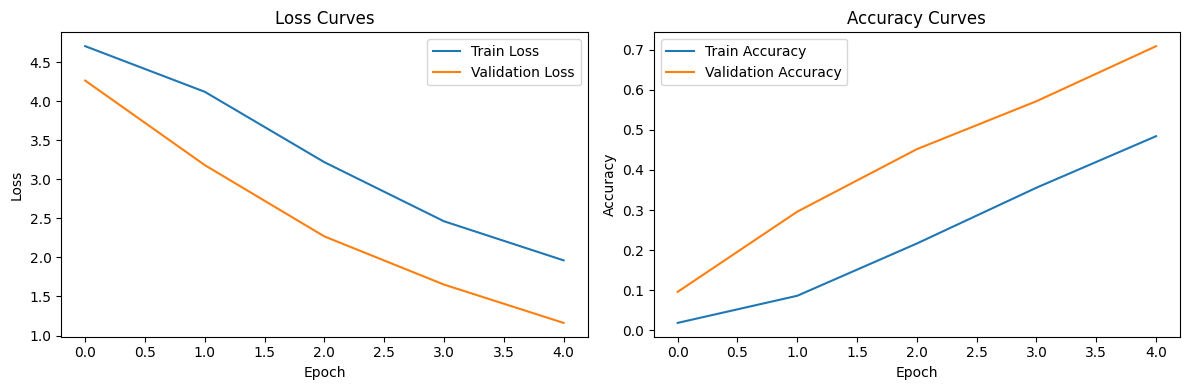

Visualizing predictions...


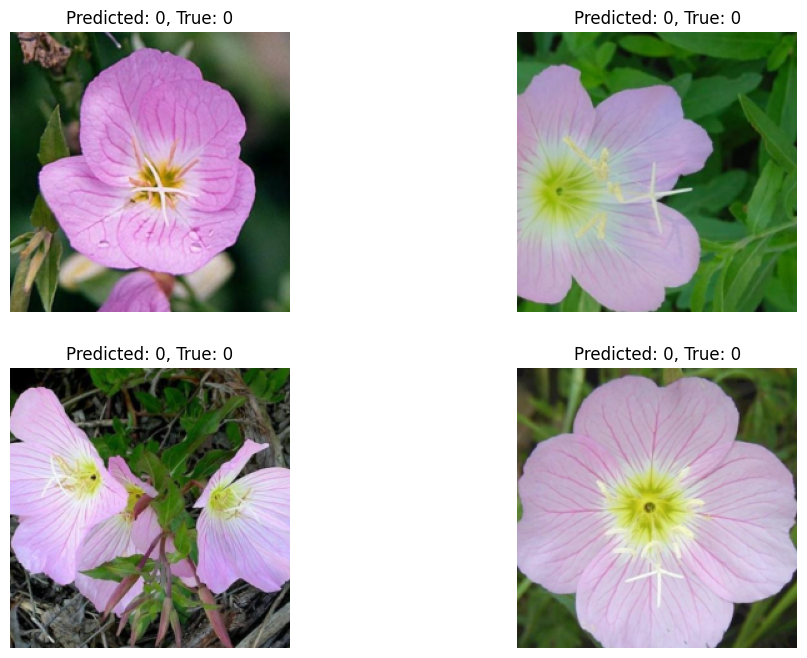

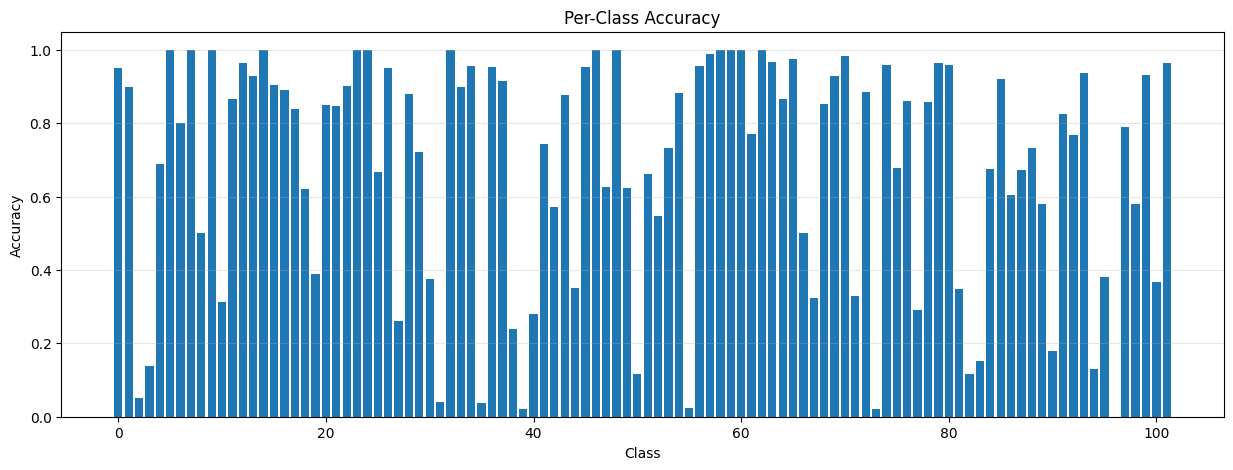

Done!


In [ ]:
# Flowers102 Image Classification with PyTorch
# This notebook demonstrates how to build an image classifier for the Oxford Flowers102 dataset

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import time
import os
from torch.utils.data import DataLoader
from torchvision.datasets import Flowers102

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define data transformations
# We'll use different transformations for training and validation
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the Flowers102 dataset
# If the dataset is not downloaded, it will be downloaded automatically
print("Loading Flowers102 dataset...")
root = './data'
train_dataset = Flowers102(root=root, split='train', transform=train_transforms, download=True)
val_dataset = Flowers102(root=root, split='val', transform=val_transforms, download=True)
test_dataset = Flowers102(root=root, split='test', transform=val_transforms, download=True)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

# Define the model
# We'll use a pre-trained ResNet-50 model and fine-tune it for Flowers102 dataset
def create_model():
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

    # Freeze early layers
    for param in list(model.parameters())[:-30]:
        param.requires_grad = False

    # Modify the final fully connected layer for 102 flower classes
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_features, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, 102)
    )

    return model

model = create_model().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW([
    {'params': [param for name, param in model.named_parameters() if 'fc' not in name], 'lr': 1e-4},
    {'params': model.fc.parameters(), 'lr': 1e-3}
], weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Function to train the model for one epoch
def train_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in data_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(data_loader.dataset)
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

# Function to evaluate the model
def evaluate(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(data_loader.dataset)
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

# Function to visualize some examples with predictions
def visualize_predictions(model, data_loader, device, num_images=4):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(12, 8))

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                if images_so_far >= num_images:
                    return

                images_so_far += 1
                ax = plt.subplot(2, num_images//2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {preds[j]}, True: {labels[j]}')

                # Unnormalize the image
                img = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img = std * img + mean
                img = np.clip(img, 0, 1)

                ax.imshow(img)

# Main training loop
num_epochs = 5
best_val_acc = 0.0
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

print("Starting training...")
for epoch in range(num_epochs):
    start_time = time.time()

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # Evaluate
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    # Update learning rate
    scheduler.step(val_loss)

    # Save the model if validation accuracy improved
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_flowers102_model.pth')
        print(f"Model saved with val_acc: {val_acc:.4f}")

    # Record history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    epoch_time = time.time() - start_time
    print(f"Epoch {epoch+1}/{num_epochs} - {epoch_time:.1f}s - train_loss: {train_loss:.4f} - train_acc: {train_acc:.4f} - val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f}")

# Load the best model and evaluate on test set
print("Loading best model and evaluating on test set...")
model.load_state_dict(torch.load('best_flowers102_model.pth'))
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Test accuracy: {test_acc:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')

plt.tight_layout()
plt.show()

# Visualize some predictions
print("Visualizing predictions...")
visualize_predictions(model, test_loader, device)

# Function to get per-class accuracy
def get_class_accuracy(model, data_loader, device, num_classes=102):
    model.eval()
    class_correct = [0] * num_classes
    class_total = [0] * num_classes

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += (predicted[i] == label).item()
                class_total[label] += 1

    class_acc = []
    for i in range(num_classes):
        if class_total[i] > 0:
            accuracy = class_correct[i] / class_total[i]
            class_acc.append((i, accuracy))

    return class_acc

# Get per-class accuracy
class_accuracies = get_class_accuracy(model, test_loader, device)

# Plot the class accuracies
plt.figure(figsize=(15, 5))
classes, accs = zip(*sorted(class_accuracies))
plt.bar(classes, accs)
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy')
plt.grid(axis='y', alpha=0.3)
plt.show()

# Function to make a prediction on a single image
def predict_single_image(model, image_path, transform, device):
    from PIL import Image

    # Load and transform the image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Make prediction
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)[0]

    # Get top 5 predictions
    top5_probs, top5_classes = torch.topk(probabilities, 5)

    return top5_classes.cpu().numpy(), top5_probs.cpu().numpy()

# Example of how to use the prediction function (commented out as it needs a specific image path)
"""
image_path = 'path/to/your/flower/image.jpg'
top5_classes, top5_probs = predict_single_image(model, image_path, val_transforms, device)
print("Top 5 predictions:")
for i, (cls, prob) in enumerate(zip(top5_classes, top5_probs)):
    print(f"{i+1}. Class {cls}: {prob:.4f}")
"""

print("Done!")